In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"juandiegocastrillon","key":"2cf61d26a0253db446a33a7d112393d2"}'}

In [ ]:
!pip install kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d sujallimje/plant-pathogens

Dataset URL: https://www.kaggle.com/datasets/sujallimje/plant-pathogens
License(s): CC-BY-NC-SA-4.0
100% 23.7G/23.7G [06:17<00:00, 96.4MB/s]
100% 23.7G/23.7G [06:17<00:00, 67.3MB/s]


In [ ]:
import os
import random
import zipfile
import shutil  # Para eliminar carpetas
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from PIL import Image  # Importa la biblioteca para manipular imágenes
from tqdm import tqdm

In [ ]:
# Variables de configuración
zip_path = 'plant-pathogens.zip'
extract_path = 'plant-pathogens'
classes = ['bacteria', 'fungus', 'healthy']
max_images_per_class = 10000
train_split = 8000  # 80% de 10,000
test_split = 2000   # 20% de 10,000

# Crear directorios de train y test en la raíz
train_dir = os.path.join(extract_path, 'train')
test_dir = os.path.join(extract_path, 'test')

# Limpiar carpetas de train y test si ya existen para evitar conflictos
if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
if os.path.exists(test_dir):
    shutil.rmtree(test_dir)

# Ahora, crear carpetas vacías nuevamente
for cls in classes:
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)

# Leer el contenido del ZIP y clasificar archivos por clase
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    all_files = zip_ref.namelist()

    # Crear diccionario para almacenar las imágenes de cada clase
    class_files = {cls: [] for cls in classes}

    # Filtrar los archivos de cada clase y limitar a 10,000 imágenes si es necesario
    for file in all_files:
        for cls in classes:
            if f"/{cls}/" in file and file.lower().endswith(('.jpg', '.jpeg', '.png')):
                class_files[cls].append(file)

    # Asegurarse de que cada clase tenga exactamente 10,000 imágenes (o menos si no hay suficientes)
    for cls in classes:
        if len(class_files[cls]) > max_images_per_class:
            class_files[cls] = random.sample(class_files[cls], max_images_per_class)

# Extraer y dividir las imágenes entre entrenamiento y prueba
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    for cls, files in class_files.items():
        print(f"Procesando clase '{cls}' con {len(files)} imágenes seleccionadas.")

        # Comprobar si hay exactamente 10,000 imágenes en la clase
        if len(files) != max_images_per_class:
            print(f"Advertencia: La clase '{cls}' no tiene exactamente 10,000 imágenes (tiene {len(files)}).")

        # Dividir en 8,000 para train y 2,000 para test
        train_files = files[:train_split]
        test_files = files[train_split:train_split + test_split]

        # Extraer y mover archivos a los directorios correspondientes
        print(f"Extrayendo {len(train_files)} imágenes de entrenamiento y {len(test_files)} de prueba para '{cls}'...")

        # Extraer imágenes de entrenamiento
        for file in tqdm(train_files, desc=f"Descomprimiendo {cls} - train"):
            zip_ref.extract(file, extract_path)
            os.rename(os.path.join(extract_path, file), os.path.join(train_dir, cls, os.path.basename(file)))

        # Extraer imágenes de prueba
        for file in tqdm(test_files, desc=f"Descomprimiendo {cls} - test"):
            zip_ref.extract(file, extract_path)
            os.rename(os.path.join(extract_path, file), os.path.join(test_dir, cls, os.path.basename(file)))

print("Organización y descompresión completadas.")


Procesando clase 'bacteria' con 10000 imágenes seleccionadas.
Extrayendo 8000 imágenes de entrenamiento y 2000 de prueba para 'bacteria'...


Descomprimiendo bacteria - test: 100%|██████████| 2000/2000 [00:02<00:00, 771.63it/s]


Procesando clase 'fungus' con 10000 imágenes seleccionadas.
Extrayendo 8000 imágenes de entrenamiento y 2000 de prueba para 'fungus'...


Descomprimiendo fungus - test: 100%|██████████| 2000/2000 [00:06<00:00, 307.06it/s]


Procesando clase 'healthy' con 10000 imágenes seleccionadas.
Extrayendo 8000 imágenes de entrenamiento y 2000 de prueba para 'healthy'...


Descomprimiendo healthy - test: 100%|██████████| 2000/2000 [00:07<00:00, 258.11it/s]

Organización y descompresión completadas.


In [ ]:
# Verificación de la cantidad de imágenes en cada clase
def count_images_in_dir(dir_path):
    return len([file for file in os.listdir(dir_path) if file.lower().endswith(('.jpg', '.jpeg', '.png'))])

# Validación de la estructura y conteo de imágenes
for cls in classes:
    train_class_dir = os.path.join(train_dir, cls)
    test_class_dir = os.path.join(test_dir, cls)

    if os.path.exists(train_class_dir) and os.path.exists(test_class_dir):
        print(f"Clase '{cls}': directorios de train y test encontrados.")

        # Contar imágenes en train y test
        train_count = count_images_in_dir(train_class_dir)
        test_count = count_images_in_dir(test_class_dir)

        # Validar la cantidad de imágenes
        total_count = train_count + test_count
        if total_count == 0:
            print(f"  Advertencia: No se encontraron imágenes para la clase '{cls}'.")
        else:
            train_ratio = train_count / total_count
            test_ratio = test_count / total_count
            print(f"  Total de imágenes: {total_count}")
            print(f"  Imágenes en train: {train_count} ({train_ratio:.2%})")
            print(f"  Imágenes en test: {test_count} ({test_ratio:.2%})")

            # Validar las proporciones
            if abs(train_ratio - 0.8) < 0.01 and abs(test_ratio - 0.2) < 0.01:
                print("  Las proporciones de train/test están dentro del rango esperado.")
            else:
                print("  Advertencia: Las proporciones de train/test no coinciden con el 80/20 esperado.")
    else:
        print(f"Advertencia: Faltan carpetas de train o test para la clase '{cls}'.")


Clase 'bacteria': directorios de train y test encontrados.
  Total de imágenes: 10000
  Imágenes en train: 8000 (80.00%)
  Imágenes en test: 2000 (20.00%)
  Las proporciones de train/test están dentro del rango esperado.
Clase 'fungus': directorios de train y test encontrados.
  Total de imágenes: 10000
  Imágenes en train: 8000 (80.00%)
  Imágenes en test: 2000 (20.00%)
  Las proporciones de train/test están dentro del rango esperado.
Clase 'healthy': directorios de train y test encontrados.
  Total de imágenes: 10000
  Imágenes en train: 8000 (80.00%)
  Imágenes en test: 2000 (20.00%)
  Las proporciones de train/test están dentro del rango esperado.


In [ ]:
# Limpieza de carpetas adicionales si existen
base_path = 'plant-pathogens'
additional_paths = ['images', 'pathogen', 'filtered_dataset']

# Eliminar las carpetas especificadas si existen
for folder in additional_paths:
    folder_path = os.path.join(base_path, folder)
    if os.path.exists(folder_path):
        shutil.rmtree(folder_path)
        print(f"Carpeta '{folder}' eliminada exitosamente.")
    else:
        print(f"Carpeta '{folder}' no encontrada, no se requiere eliminación.")

print("Limpieza completada.")

Carpeta 'images' no encontrada, no se requiere eliminación.
Carpeta 'pathogen' eliminada exitosamente.
Carpeta 'filtered_dataset' no encontrada, no se requiere eliminación.
Limpieza completada.


In [ ]:
train_path = os.path.join(base_path, 'train')
test_path = os.path.join(base_path, 'test')

# Tamaño de imagen y batch
image_size = (128, 128)
batch_size = 16

# Función de carga y normalización de imágenes
def cargar_y_normalizar(imagen_path, etiqueta):
    imagen = tf.io.read_file(imagen_path)  # Leer archivo de imagen
    imagen = tf.image.decode_jpeg(imagen, channels=3)  # Decodificar imagen JPEG
    imagen = tf.image.resize(imagen, image_size)  # Redimensionar a tamaño deseado
    imagen = tf.cast(imagen, tf.float32) / 255.0  # Normalizar de 0-255 a 0-1
    return imagen, etiqueta

# Función para preparar datasets desde un directorio
def crear_dataset(directorio):
    clases = os.listdir(directorio)
    imagenes = []
    etiquetas = []

    for etiqueta, clase in enumerate(clases):
        clase_dir = os.path.join(directorio, clase)
        if os.path.isdir(clase_dir):
            for imagen_nombre in os.listdir(clase_dir):
                imagen_path = os.path.join(clase_dir, imagen_nombre)
                imagenes.append(imagen_path)
                etiquetas.append(etiqueta)

    # Mezcla las listas de imágenes y etiquetas de manera sincronizada
    data = list(zip(imagenes, etiquetas))
    random.shuffle(data)
    imagenes, etiquetas = zip(*data)  # Volver a dividir las listas mezcladas

    # Crear el dataset a partir de las rutas y etiquetas
    dataset = tf.data.Dataset.from_tensor_slices((list(imagenes), list(etiquetas)))
    dataset = dataset.map(cargar_y_normalizar, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

# Crear y preprocesar los datasets de entrenamiento y prueba
train_dataset = crear_dataset(train_path)
test_dataset = crear_dataset(test_path)

# Configurar batch, cache, y prefetch para optimizar el rendimiento
train_dataset = train_dataset.cache().shuffle(5000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Verificar el tamaño de un lote para entrenamiento y prueba
for image_batch, label_batch in train_dataset.take(1):
    print("Shape of training images:", image_batch.shape)
    print("Shape of training labels:", label_batch.shape)

for image_batch, label_batch in test_dataset.take(1):
    print("Shape of test images:", image_batch.shape)
    print("Shape of test labels:", label_batch.shape)

# `train_dataset` y `test_dataset` están listos y optimizados para entrenar en una red.


Shape of training images: (16, 128, 128, 3)
Shape of training labels: (16,)
Shape of test images: (16, 128, 128, 3)
Shape of test labels: (16,)


In [ ]:
# Tomar algunos lotes y mostrar las etiquetas
for image_batch, label_batch in test_dataset.take(5):
    print("Etiquetas en el lote:", label_batch.numpy())


Etiquetas en el lote: [2 0 1 1 0 2 1 1 0 2 0 2 1 1 1 2]
Etiquetas en el lote: [1 1 0 2 0 0 1 2 2 2 0 1 1 1 2 2]
Etiquetas en el lote: [1 0 2 0 2 1 2 1 1 0 2 1 1 1 1 2]
Etiquetas en el lote: [1 2 2 2 1 2 2 1 2 2 1 0 1 1 2 0]
Etiquetas en el lote: [2 2 0 2 2 2 0 1 0 0 0 0 2 1 1 1]


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras import layers as tfl

In [ ]:
# Cargar el modelo MobileNetV2 desde TensorFlow Hub
mobilenet_v2_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"  # Para feature extraction
IMAGE_SHAPE = (128, 128)

In [ ]:
# Función que define el modelo para clasificación de tres clases basado en MobileNetV2
def hojas_model(image_shape=IMAGE_SHAPE, num_classes=3, data_augmentation=None):
    '''Define un modelo tf.keras para clasificación con MobileNetV2 como base.
    Arguments:
        image_shape -- tupla, dimensiones de entrada de las imágenes (default: (128, 128))
        num_classes -- int, número de clases para clasificación (default: 3)
        data_augmentation -- función o capa de aumentación de datos (default: None)
    Returns:
        tf.keras.Model
    '''
    input_shape = image_shape + (3,) # Forma de entrada para imágenes RGB

    # Cargar el modelo base MobileNetV2 preentrenado en ImageNet y congelar sus pesos
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False,  # Quitar la capa superior
                                                   weights='imagenet')
    base_model.trainable = True  # Congela el modelo base para que sus capas no se entrenen


    # Capa de entrada
    inputs = tf.keras.Input(shape=input_shape)

    # Aumentación de datos, si se proporciona
    x = data_augmentation(inputs) if data_augmentation else inputs

    # Preprocesamiento específico de MobileNetV2
    x = preprocess_input(x)

    # Paso por el modelo base
    x = base_model(x, training=False)

    # Pooling global para reducir las dimensiones y regularización con Dropout
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tfl.Dropout(0.5)(x)  # Aumentar Dropout
    x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = tfl.Dropout(0.3)(x)  # Añadir un segundo Dropout
    prediction_layer = tf.keras.layers.Dense(num_classes, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.01))

    # Definir la salida
    outputs = prediction_layer(x)

    # Crear el modelo
    model = tf.keras.Model(inputs, outputs)

    return model, base_model

# Resumen del modelo
#model.summary()

In [ ]:
model2, base_model = hojas_model(IMAGE_SHAPE, data_augmentation=None)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Crear y compilar el modelo
#model = hojas_model(image_shape=IMAGE_SHAPE, num_classes=3, data_augmentation=None)
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),  # Cambiado para clasificación de 3 clases
              metrics=['accuracy'])

# Entrenamiento del modelo
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
history = model2.fit(train_dataset, validation_data=test_dataset, epochs=15, callbacks=[reduce_lr])

Epoch 1/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 366s 184ms/step - accuracy: 0.7067 - loss: 2.8358 - val_accuracy: 0.3130 - val_loss: 3.0588 - learning_rate: 1.0000e-04
Epoch 2/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 40s 27ms/step - accuracy: 0.8783 - loss: 1.4879 - val_accuracy: 0.3332 - val_loss: 2.4303 - learning_rate: 1.0000e-04
Epoch 3/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 41s 27ms/step - accuracy: 0.9122 - loss: 0.8093 - val_accuracy: 0.3163 - val_loss: 1.5320 - learning_rate: 1.0000e-04
Epoch 4/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 41s 27ms/step - accuracy: 0.9328 - loss: 0.4455 - val_accuracy: 0.4287 - val_loss: 2.9149 - learning_rate: 1.0000e-04
Epoch 5/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 41s 27ms/step - accuracy: 0.9474 - loss: 0.2802 - val_accuracy: 0.4232 - val_loss: 2.4736 - learning_rate: 1.0000e-04
Epoch 6/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 41s 27ms/step - accuracy: 0.9663 - loss: 0.1790 - val_accuracy: 0.3395 - val_loss: 3.4820 - learning_rate: 5.0000e-05
Epoch 7/15
1500/1500 ━━━━━━━━━━━━━━━━━

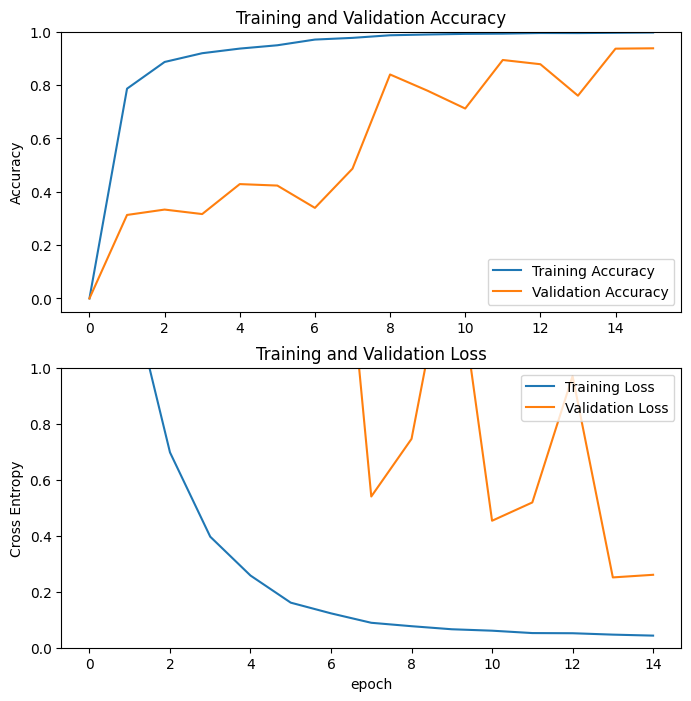

In [ ]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
model2.evaluate(test_dataset)

375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9415 - loss: 0.2788


[0.2604384124279022, 0.937833309173584]

375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step


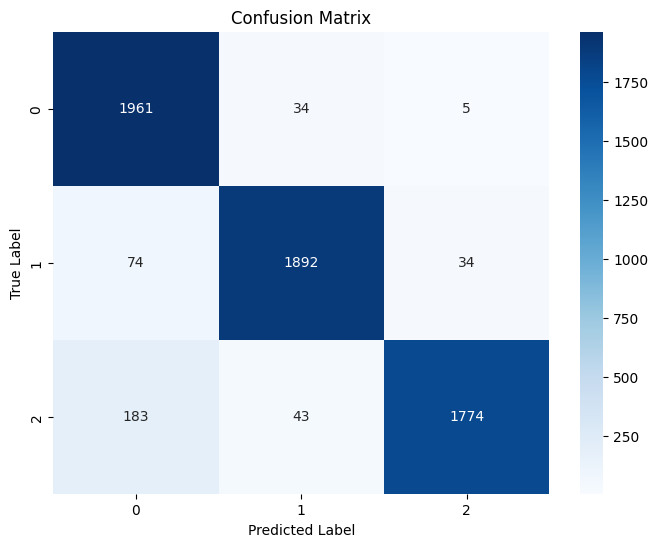

              precision    recall  f1-score   support

     Clase 0       0.88      0.98      0.93      2000
     Clase 1       0.96      0.95      0.95      2000
     Clase 2       0.98      0.89      0.93      2000

    accuracy                           0.94      6000
   macro avg       0.94      0.94      0.94      6000
weighted avg       0.94      0.94      0.94      6000



In [ ]:
# 1. Obtener las predicciones del modelo en el conjunto de validación
# Asumiendo que `test_dataset` es un tf.data.Dataset con los datos de validación
y_pred = np.argmax(model2.predict(test_dataset), axis=-1)

# 2. Obtener las etiquetas reales del conjunto de validación
# Para extraer etiquetas, iteramos sobre el conjunto y acumulamos los valores reales
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

# 3. Crear la matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# 4. Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Opcional: imprimir reporte de clasificación
print(classification_report(y_true, y_pred, target_names=['Clase 0', 'Clase 1', 'Clase 2']))


In [ ]:
model2.save('miniproyecto3_model.h5')

In [ ]:
model2.save('miniproyecto3_model.keras')

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model2)
model2_tflite = converter.convert()
open('miniproyecto3_model.tflite', 'wb').write(model2_tflite)

Saved artifact at '/tmp/tmpsi4ue6uh'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  138411408330416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138411408332528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138411408335168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138411408334112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138411408333232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138411408339568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138411408339216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138411408340096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138411408340272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138411408341152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1384114083

9523236

In [ ]:
converter2 = tf.lite.TFLiteConverter.from_keras_model(model2)
converter2.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter2.convert()
open("/content/miniproyecto3_model.tflite","wb").write(tflite_quant_model)

Saved artifact at '/tmp/tmpsvuvltoe'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  138411408330416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138411408332528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138411408335168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138411408334112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138411408333232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138411408339568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138411408339216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138411408340096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138411408340272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138411408341152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1384114083

2675256

In [ ]:
from google.colab import files
files.download('/content/miniproyecto3_model.tflite')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>